In [1]:
!pip install yake --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 2.2 MB/s eta 0:00:00


In [2]:
import requests
from tqdm.auto import tqdm
from datetime import datetime
import pandas as pd
import json
from pprint import pprint
from yake import KeywordExtractor

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from pymystem3 import Mystem
import re

import matplotlib.pyplot as plt

import random
import math

In [3]:
TOKEN = "879b7291879b7291879b72913784b677ef8879b879b7291e0421bd061a34b89604564d7"
VERSION = "5.130"

In [4]:
group_members = "https://api.vk.com/method/groups.getMembers"
wall_get_url = "https://api.vk.com/method/wall.get"
users_get_url = "https://api.vk.com/method/users.get??user_id={user_id}&fields=sex,city,bdate,&access_token={access_token}&v={api_version}"

In [5]:
groups = ["student_tf",
          "sechenovrunnersclub",
          "studathletics",
          "ranepa_run",
          "runlab",
          "begvpitere",
          "enjoytherunspb",
          "goldenringrun",
          "runcomrun",
          "moscowmarathon"]

# Делаем статистику по ключевым словам

In [8]:
df = pd.DataFrame({"group_shortname": groups})

In [10]:
# Функция, которая выгружает весь текст с последних 300 постов сообщества.

def load_posts(group:str):

    full_text = ''

    data_text = requests.get(
        wall_get_url,
        params={
            "owner_id": group,
            "count": 300,
            "v": VERSION,
            "access_token": TOKEN
        }
    ).json()

    for item in data_text['response']['items']:
        if 'text' in item:
            #pprint(item['text'].replace('\n', ''))
            full_text += item['text'].replace('\n', '')


    return full_text

In [12]:
# Функция, которая извлекает ключевые слова из всех собранных текстов сообщества
def find_keywords(text):

    custom_kw_extractor = KeywordExtractor(lan='ru', n=1, top=15)
    keywords = custom_kw_extractor.extract_keywords(text)
    keywords = [(keyword[0], round(keyword[1], 8)) for keyword in keywords]

    return keywords

In [13]:
df["texts"] = df["group_shortname"].apply(load_posts)

In [14]:
df['keywords'] = df['texts'].apply(find_keywords)

In [15]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
sw = stopwords.words('russian')

In [17]:
# Функция, которая лемматизирует тексты, чтобы потом можно было посчитать частотность лемм
def clear_text(text):

    m_stem = Mystem()

    # В постах в соц.сетяъ часто встречаются эмоджи. Поэтому нужно очистить тексты и от них.
    # Реализация функции взята с: https://ru.stackoverflow.com/questions/1501684/%D0%9A%D0%B0%D0%BA-%D1%83%D0%B4%D0%B0%D0%BB%D0%B8%D1%82%D1%8C-%D1%8D%D0%BC%D0%BE%D0%B4%D0%B7%D0%B8-%D0%B8%D0%B7-%D1%81%D1%82%D1%80%D0%BE%D0%BA%D0%B8-%D0%BD%D0%B0-python
    def deEmojify(lines):
        regrex_pattern = re.compile(pattern = "["
                                    u"\U00000000-\U00000009"
                                    u"\U0000000B-\U0000001F"
                                    u"\U00000080-\U00000400"
                                    u"\U00000402-\U0000040F"
                                    u"\U00000450-\U00000450"
                                    u"\U00000452-\U0010FFFF"
                                    "]+", flags = re.UNICODE)
        return regrex_pattern.sub(r'',lines)

    clear_sentences =[]
    for sentence in sent_tokenize(deEmojify(text), language='russian'):
        clear_sent = ' '.join([w.lower() for w in word_tokenize(sentence, language='russian') if ((w.lower() not in sw) and w.isalpha())])
        lemmas = ' '.join(m_stem.lemmatize(clear_sent))
        clear_sentences.append(lemmas)
    clear_text = ''.join(clear_sentences)
    return clear_text

In [18]:
df['cleared_texts'] = df['texts'].apply(clear_text)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [20]:
# Функция считает, сколько раз в тексте встретилась каждая лемма
# Идея в том, чтобы затем лемматизировать ключевые слова и найти их частотность из словаря, полученного с помощью этой функции

def count_frequency(cleared_text: str):

  lemma_counts = dict()

  all_lemmas = cleared_text.split(' ')
  for lemma in all_lemmas:
    if lemma != '':
      lemma_counts.setdefault(lemma, 0)
      lemma_counts[lemma] += 1

  return lemma_counts


In [21]:
df['lemmas_frequency'] = df['cleared_texts'].apply(count_frequency)

In [22]:
# Функция, которая лемматизирует клюевые слова
def lemmatize_keywords(keywords: list):

  kw_lemmas = []

  m_stem = Mystem()

  for keyword in keywords:
    kw_lemma = m_stem.lemmatize(keyword[0])
    kw_lemmas.append(kw_lemma[0])

  return kw_lemmas

In [23]:
df['keyword_lemmas'] = df['keywords'].apply(lemmatize_keywords)

In [25]:
# Здесь выкинуты некоторые нерусскоязычные леммы, которые не получилось автоматически извлечь из текста
# Функция, которая находит частотность ключевых слов по ранее полученно словарю частотности лемм
# На данном этапе это даже не частотность, а количество раз, которое встретилось ключевое слово в текстах сообщества
def count_kw_freq(keyword_lemmas, lemmas_frequency):

  kw_freq = dict()

  for lemma in keyword_lemmas:
    if lemma in lemmas_frequency:
      kw_freq[lemma] = lemmas_frequency[lemma]

  return kw_freq

In [26]:
# https://sky.pro/media/primenenie-funkczii-k-dvum-stolbczam-pandas-dataframe/

df['keyword_frequency'] = df.apply(lambda row: count_kw_freq(row['keyword_lemmas'], row['lemmas_frequency']), axis=1)

In [28]:
# Функция, которая нормализует полученные данных
# Переходим от количества встреченных ключевых слов к их доле от полного числа лемм (= кол-ву слов без стоп-слов) в текстах сообщества
# Для этого делим число раз, которое всретилось ключевое слово, на общее число слов в текстах некоторого сообщества
def normalize_keyword_frequency(d: dict):
  total_lemmas_count = sum(d.values())
  for lemma in d:
    d[lemma] = round(d[lemma] / total_lemmas_count, 2)

  return d

In [29]:
df['normalized_keyword_frequency'] = df['keyword_frequency'].apply(normalize_keyword_frequency)

In [31]:
# Функция, которая рисует график частотности ключевых слов для конкретного сообщества
def draw_hist(kw_freq: dict, color):

  names = list(kw_freq.keys())
  values = list(kw_freq.values())

  plt.figure(figsize=(12, 4)) #Изменяем размер графика
  plt.bar(names, values, color=color, width=0.5) #Изменяем цвет и ширину столбцов
  plt.xlabel("Леммы ключевых слов", fontsize=12) #Изменяем размер шрифта
  plt.ylabel("Частотность леммы", fontsize=12)
  plt.title("Частотность ключевых слов", fontsize=14)
  plt.xticks(fontsize=10) #Изменяем размер шрифта на оси X
  plt.xticks(rotation=20)
  plt.yticks(fontsize=10) #Изменяем размер шрифта на оси Y

  plt.show()


# Графики частотности лемм ключевых слов по каждому сообществу

Тут просто применяю функцию, рисующую гистограмму, к данным по каждому сообществу

Беговой Университет

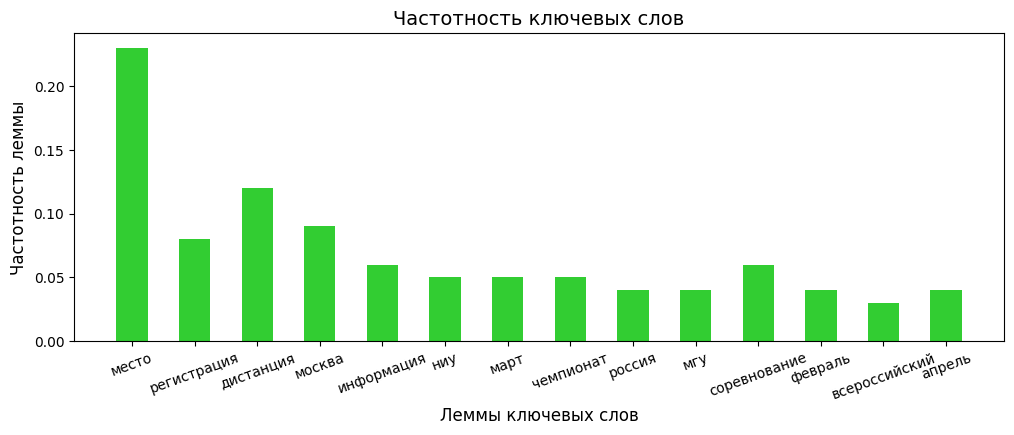

In [32]:
draw_hist(df['normalized_keyword_frequency'].iloc[0], 'limegreen')

Sechenov Runners Club

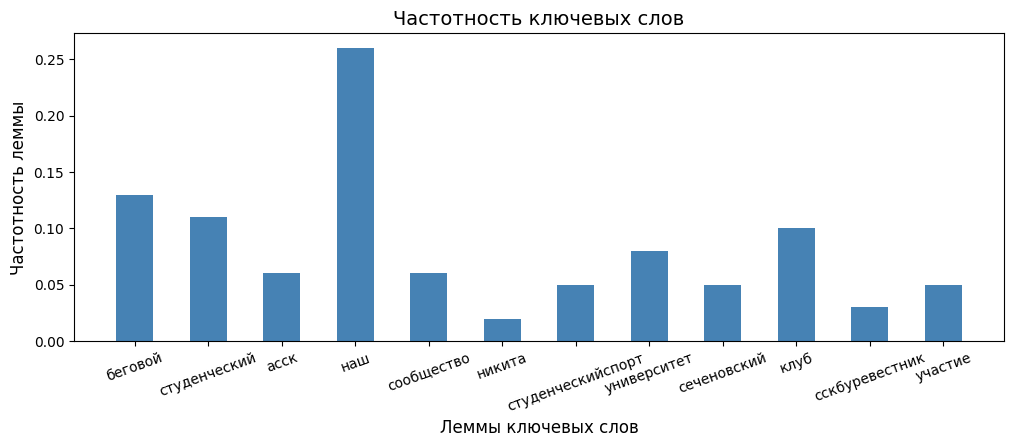

In [33]:
draw_hist(df['normalized_keyword_frequency'].iloc[1], 'steelblue')

Студенческая лига легкой атлетики

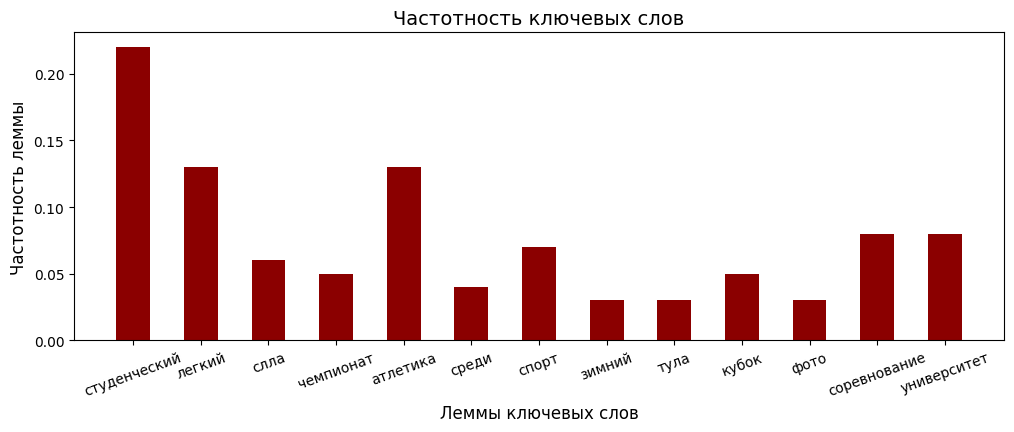

In [34]:
draw_hist(df['normalized_keyword_frequency'].iloc[2], 'darkred')

Академия Бега

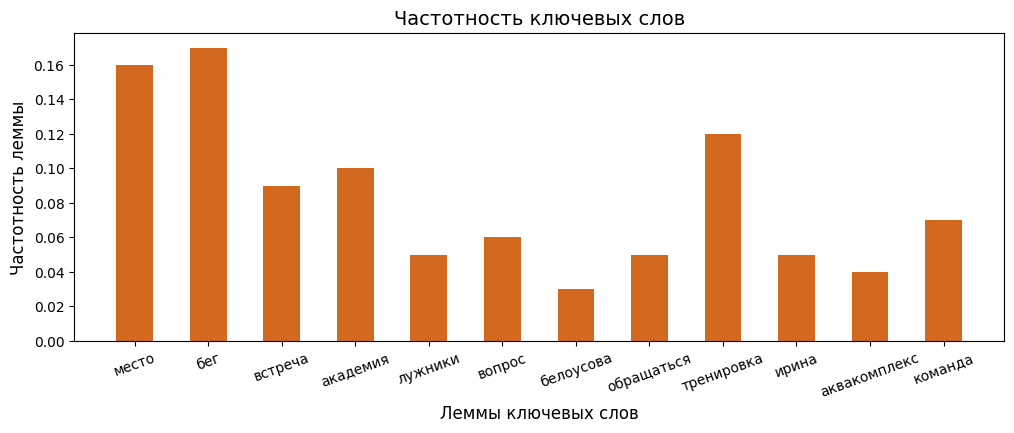

In [35]:
draw_hist(df['normalized_keyword_frequency'].iloc[3], 'chocolate')

Лаборатория Бега Runlab

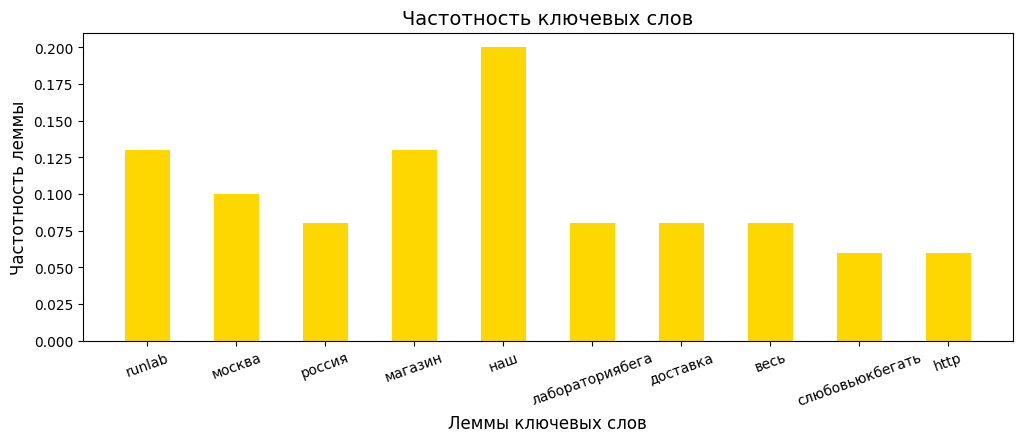

In [36]:
draw_hist(df['normalized_keyword_frequency'].iloc[4], 'gold')

Бег в Питере

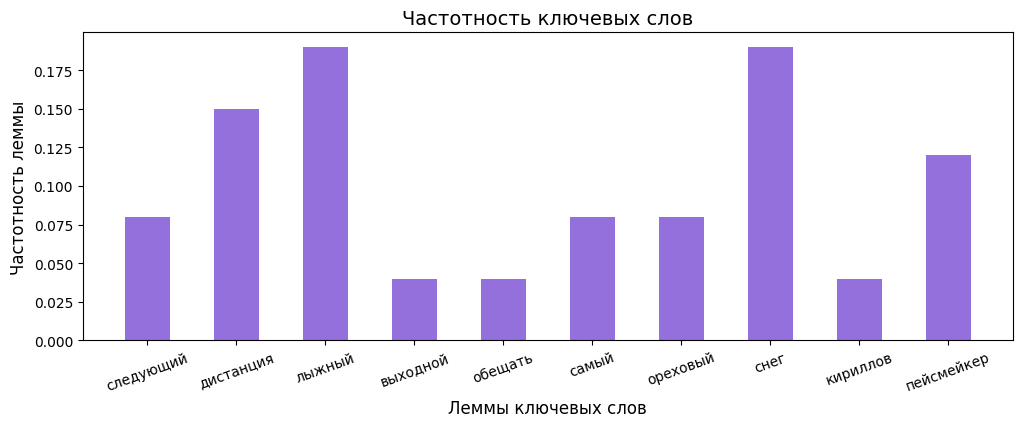

In [37]:
draw_hist(df['normalized_keyword_frequency'].iloc[5], 'mediumpurple')

Бег с Удовольствием / Спб

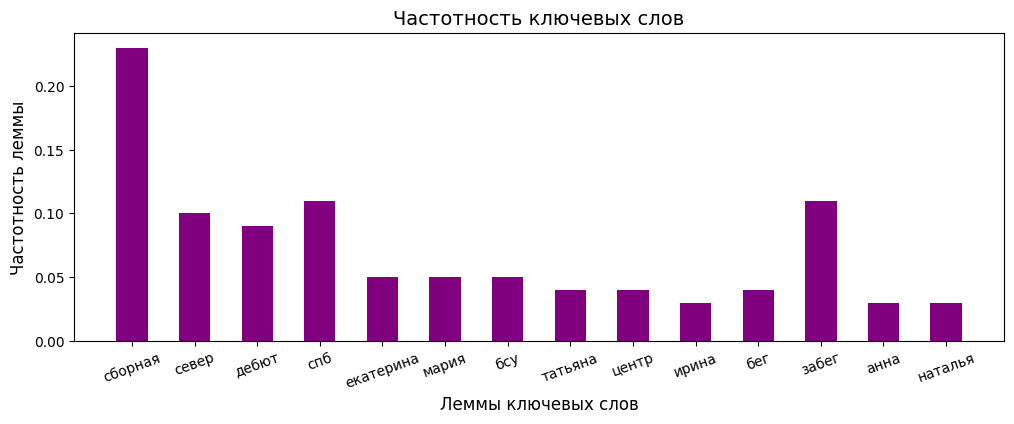

In [38]:
draw_hist(df['normalized_keyword_frequency'].iloc[6], 'purple')

Бегом по Золотому кольцу

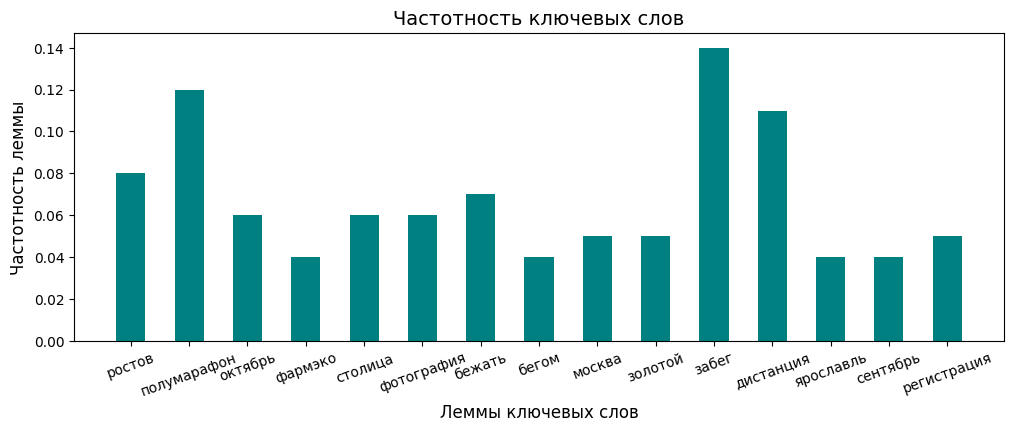

In [39]:
draw_hist(df['normalized_keyword_frequency'].iloc[7], 'teal')

Беговое сообщество

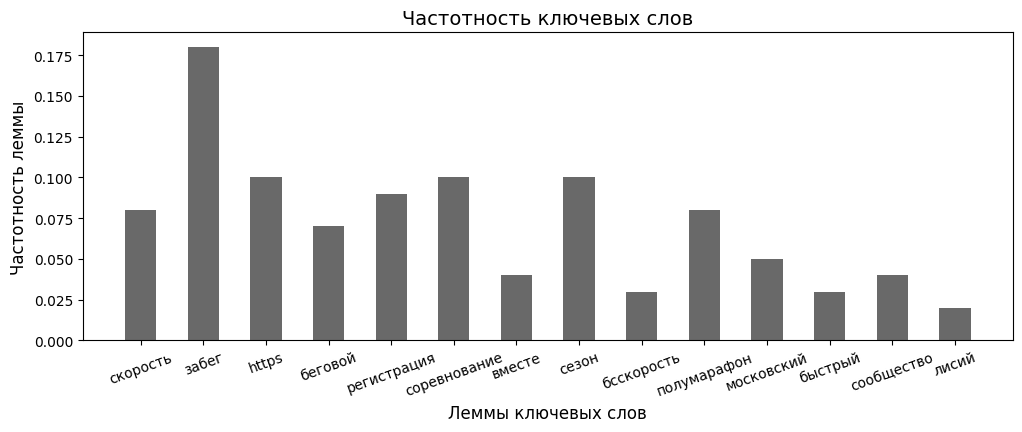

In [40]:
draw_hist(df['normalized_keyword_frequency'].iloc[8], 'dimgray')

Московский Марафон

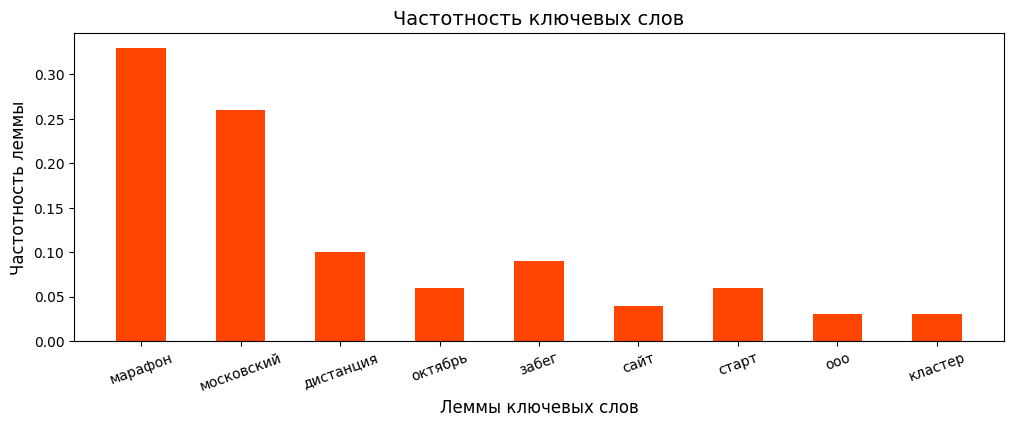

In [41]:
draw_hist(df['normalized_keyword_frequency'].iloc[9], 'orangered')

# Общий график

In [42]:
# Готовим данные для общего графика по всем сообществам
# Для начала собираем все леммы
all_run_lemmas = []

for row in df.itertuples():
    for lemma in row.normalized_keyword_frequency:
      if lemma not in all_run_lemmas:
        all_run_lemmas.append(lemma)


In [45]:
# Теперь для каждого сообщества делаем словарь со всеми леммами ключевых слов. Тем ключевым словам, которые не встретились в постах сообщества присваиваем частотность 0.
# Сортируем словарь, чтобы в словарях каждого сообщества леммы шли в одном и том же порядке. Это понадобится для построения сводной гистограммы.
def extend_lemmas_freq(d: dict):
  for lemma in all_run_lemmas:
    d.setdefault(lemma, 0)
  return dict(sorted(d.items()))

In [46]:
df['full_normalized_keyword_frequency'] = df['normalized_keyword_frequency'].apply(extend_lemmas_freq)

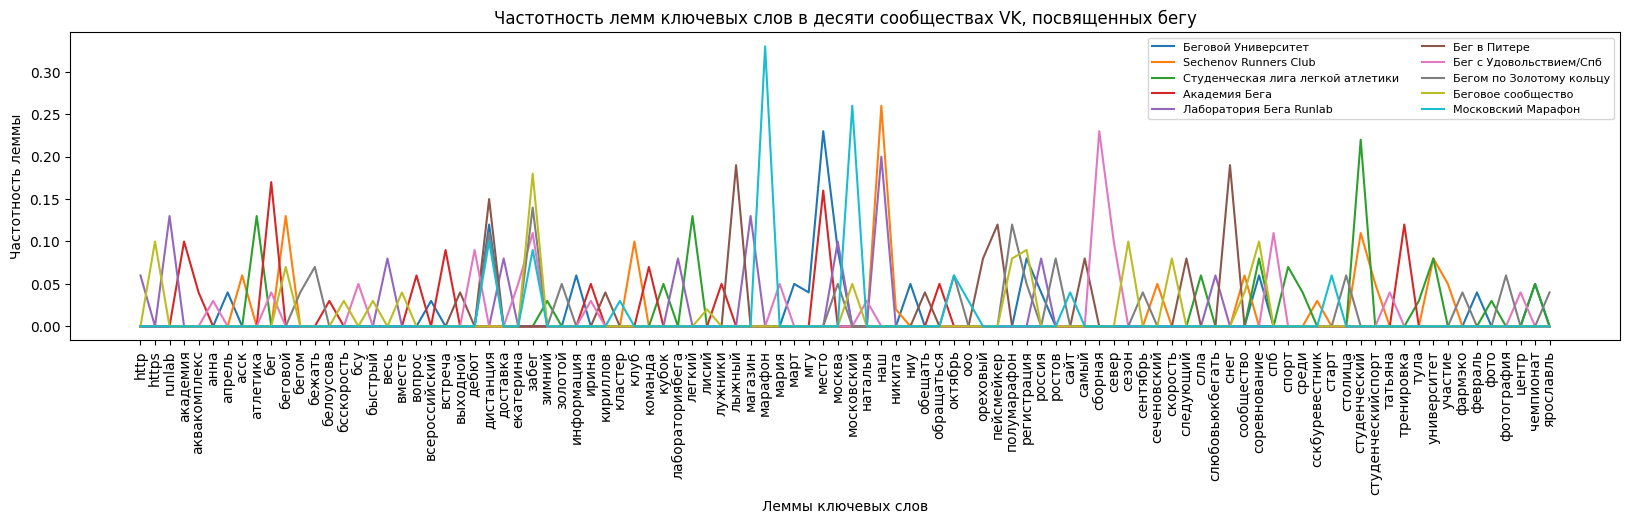

In [47]:
# Строим график
keys = sorted(all_run_lemmas)

plt.figure(figsize=(20, 4))

plt.plot(keys, df['full_normalized_keyword_frequency'].iloc[0].values(), label='Беговой Университет')
plt.plot(keys, df['full_normalized_keyword_frequency'].iloc[1].values(), label='Sechenov Runners Club')
plt.plot(keys, df['full_normalized_keyword_frequency'].iloc[2].values(), label='Студенческая лига легкой атлетики')
plt.plot(keys, df['full_normalized_keyword_frequency'].iloc[3].values(), label='Академия Бега')
plt.plot(keys, df['full_normalized_keyword_frequency'].iloc[4].values(), label='Лаборатория Бега Runlab')
plt.plot(keys, df['full_normalized_keyword_frequency'].iloc[5].values(), label='Бег в Питере')
plt.plot(keys, df['full_normalized_keyword_frequency'].iloc[6].values(), label='Бег с Удовольствием/Спб')
plt.plot(keys, df['full_normalized_keyword_frequency'].iloc[7].values(), label='Бегом по Золотому кольцу')
plt.plot(keys, df['full_normalized_keyword_frequency'].iloc[8].values(), label='Беговое сообщество')
plt.plot(keys, df['full_normalized_keyword_frequency'].iloc[9].values(), label='Московский Марафон')

plt.xlabel('Леммы ключевых слов')
plt.xticks(rotation=90)
plt.ylabel('Частотность леммы')
plt.title('Частотность лемм ключевых слов в десяти сообществах VK, посвященных бегу')
plt.legend(ncol=2, fontsize=8)
plt.show()

# Делаем статистику по полу, возрасту и месту жительства подписчиков сообщества

Здесь я не фиксировала random_state, поэтому резульаты могут отличаться от тех, которые были получены изначально.

In [48]:
# Не беру первую группу, т.к. в ней скрыты пользователи.
df2 = pd.DataFrame({'group_shortname': groups[1:]})

In [49]:
df2['group_name'] = ['Sechenov Runners Club',
                     'Студенческая лига легкой атлетики',
                     'Академия Бега',
                     'Лаборатория Бега Runlab',
                     'Бег в Питере',
                     'Бег с Удовольствием/Спб',
                     'Бегом по Золотому кольцу',
                     'Беговое сообщество',
                     'Московский Марафон']

In [50]:
# Т.к. в некоторых сообществах очень много подписчиков, дальнейшая выгрузка информации по каждому из них займет очень много времени. Поэтому для популярных сообществ выберу по 100 рандомных подписчиков.
# Функция, которая выгружает ID ста рандомных подписчиков сообщества
def load_subscribers(group: str):
  data2 = requests.get(
      group_members,
      params={
          'group_id': group,
          'access_token': TOKEN,
          'v': VERSION,
          'offset': 0
      }
  ).json()

  if len(data2['response']['items']) > 100:
    return random.sample(data2['response']['items'], 100)
  else:
    return data2['response']['items']


In [51]:
df2['members_id'] = df2['group_shortname'].apply(load_subscribers)

In [54]:
# получаем статистику по полу, городам и возрасту
# Выгружаем значения пола, города и даты рождения (откуда считаем примерный возраст) для каждого пользователя сообщества.
# Подсчитываем количество мужчин и женщин, подписанных на паблик, количество подписчиков из того или иного города и выгружаем возраста пользователей.
# Не у всех пользователей прописаны город и возраст. Поэтому статистику считаем относительно количества собранных данных по признаку, а не относительно всего числа выгруженных json-файлов.
def collect_stats(subsc_ids: list):

  cities = dict()
  sex = {'Male': 0, 'Female': 0}
  age = []

  for id in subsc_ids:

    data_user = requests.get(
          users_get_url,
          params={
              'user_id': str(id),
              'field': 'bdate',
              'access_token': TOKEN,
              'v': VERSION
          }
      ).json()

    if 'sex' in data_user['response'][0]:
      if str(data_user['response'][0]['sex']) == '1':
        sex['Female'] += 1
      elif str(data_user['response'][0]['sex']) == '2':
        sex['Male'] += 1

    if 'city' in data_user['response'][0]:
      cities.setdefault(data_user['response'][0]['city']['title'], 0)
      cities[data_user['response'][0]['city']['title']] += 1

    if 'bdate' in data_user['response'][0]:
      age_data = data_user['response'][0]['bdate'].split('.')
      if len(age_data) == 3:
        age.append(2025 - int(age_data[2]))

  return [age, cities, sex]

In [55]:
df2['stats'] = df2['members_id'].apply(collect_stats)

In [57]:
# Функция, которая по возрасту считает, сколько людей из 200 рандомных пользователей, подписанных на паблик относятся к тому или иному поколению.
# Идея в том, чтобы посотреть люди какого поколения чаще всего подписываются на паблик.
def count_generations(stats: list):
  age = stats[0]
  gen = {'A': 0, 'Z': 0, 'Y': 0, 'X': 0, 'B': 0}
  for elem in age:
    if int(elem) <= 14:
      gen['A'] += 1
    elif 14 < int(elem) <= 25:
      gen['Z'] += 1
    elif 25 < int(elem) <= 41:
      gen['Y'] += 1
    elif 41 < int(elem) <= 58:
      gen['X'] += 1
    else:
      gen['B'] += 1
  return gen

In [58]:
df2['generations'] = df2['stats'].apply(count_generations)

In [59]:
# Функция, которая считает средний возраст по выборке подписчиков паблика
def mean_age(stats: list):
  age = stats[0]
  return math.ceil(sum(age)/len(age))

In [60]:
df2['mean_age'] = df2['stats'].apply(mean_age)

In [61]:
def cities(stats: list):
  return stats[1]

In [62]:
df2['cities'] = df2['stats'].apply(cities)

In [63]:
# Функция, которая считает подписчиков из какого города больше всего в выборке
def most_popular_city(stats: list):
  cities = stats[1]
  return str(max(cities, key=cities.get))


In [64]:
df2['most_popular_city'] = df2['stats'].apply(most_popular_city)

In [66]:
# Функция, которая считает кого больше подписано на паблик, мужчин или женщин
# Считаю только долю женщин от всех подписчиков в выборке, т.к. число подписчиков мужского и женского пола скорелированно
def sex_distribution(stats: list):
  sex = stats[2]
  women_proportion = int(sex['Female'])/(int(sex['Male']) + int(sex['Female']))
  return women_proportion

In [67]:
df2['women_proportion'] = df2['stats'].apply(sex_distribution)

In [68]:
df2 = df2.drop('stats', axis=1)

In [69]:
# Функция, которая считает подписчиков из какого поколения больше всего в выборке
def most_popular_generation(gen: dict):
  return str(max(gen, key=gen.get))

In [70]:
df2['most_popular_generation'] = df2['generations'].apply(most_popular_generation)

In [72]:
df2

,group_shortname,group_name,members_id,generations,mean_age,cities,most_popular_city,women_proportion,most_popular_generation
0,sechenovrunnersclub,Sechenov Runners Club,"[272692189, 285259246, 164744668, 270792939, 4...","{'A': 0, 'Z': 33, 'Y': 2, 'X': 4, 'B': 1}",28,"{'Moscow': 44, 'Maloyaroslavets': 1, 'Yekateri...",Moscow,0.62,Z
1,studathletics,Студенческая лига легкой атлетики,"[355835933, 195397888, 174551555, 98978266, 46...","{'A': 0, 'Z': 31, 'Y': 5, 'X': 10, 'B': 3}",31,"{'Joshkar-Ola': 1, 'Moscow': 16, 'Nizhny Novgo...",Moscow,0.51,Z
2,ranepa_run,Академия Бега,"[613492694, 49565429, 365600076, 538412136, 10...","{'A': 0, 'Z': 36, 'Y': 4, 'X': 2, 'B': 1}",26,"{'Perm': 1, 'Moscow': 50, 'Krasnodar': 1, 'San...",Moscow,0.61,Z
3,runlab,Лаборатория Бега Runlab,"[34845, 380650, 736713, 531592, 463932, 526822...","{'A': 0, 'Z': 0, 'Y': 31, 'X': 12, 'B': 0}",39,"{'Saint Petersburg': 55, 'Moscow': 21, 'Vorone...",Saint Petersburg,0.40,Y
4,begvpitere,Бег в Питере,"[638187, 549276, 158950, 94714, 698034, 85092,...","{'A': 0, 'Z': 0, 'Y': 18, 'X': 14, 'B': 1}",43,"{'Saint Petersburg': 86, 'Petrozavodsk': 1, 'K...",Saint Petersburg,0.53,Y
5,enjoytherunspb,Бег с Удовольствием/Спб,"[162552, 269937, 579589, 40586, 747727, 574252...","{'A': 0, 'Z': 0, 'Y': 22, 'X': 9, 'B': 0}",40,"{'Saint Petersburg': 89, 'Kursk': 1, 'Moscow':...",Saint Petersburg,0.83,Y
6,goldenringrun,Бегом по Золотому кольцу,"[297000, 1033628, 1819934, 95058, 1600374, 936...","{'A': 0, 'Z': 0, 'Y': 25, 'X': 11, 'B': 2}",44,"{'Saint Petersburg': 21, 'Moscow': 39, 'Khanty...",Moscow,0.49,Y
7,runcomrun,Беговое сообщество,"[4590, 160892, 70784, 274486, 321960, 239617, ...","{'A': 0, 'Z': 1, 'Y': 26, 'X': 7, 'B': 0}",39,"{'Saint Petersburg': 56, 'Moscow': 23, 'Gatchi...",Saint Petersburg,0.47,Y
8,moscowmarathon,Московский Марафон,"[1613, 71917, 19482, 32720, 4083, 134252, 1645...","{'A': 0, 'Z': 0, 'Y': 33, 'X': 3, 'B': 0}",38,"{'Saint Petersburg': 20, 'Moscow': 49, 'Dubna ...",Moscow,0.43,Y


Кодируем данные для кластеризации. Т.к. среди полов и самых попуярных городов (Москва и Спб) и поколений всего два варианта (Z и Y), можно закодировать их просто как 0 и 1.

In [73]:
df_for_clust = df2[['group_name', 'most_popular_generation', 'women_proportion', 'most_popular_city']]

In [74]:
def encode_gen(gen:str):
  if gen == 'Z':
    return 0
  elif gen == 'Y':
    return 1

In [75]:
def encode_city(city:str):
  if city == 'Moscow':
    return 0
  elif city == 'Saint Petersburg':
    return 1

In [76]:
df_for_clust['encoded_gen'] = df_for_clust['most_popular_generation'].apply(encode_gen)
df_for_clust['encoded_city'] = df_for_clust['most_popular_city'].apply(encode_city)

<ipython-input-76-883d8844cf3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_clust['encoded_gen'] = df_for_clust['most_popular_generation'].apply(encode_gen)
<ipython-input-76-883d8844cf3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_clust['encoded_city'] = df_for_clust['most_popular_city'].apply(encode_city)


In [77]:
df_for_clust

,group_name,most_popular_generation,women_proportion,most_popular_city,encoded_gen,encoded_city
0,Sechenov Runners Club,Z,0.62,Moscow,0,0
1,Студенческая лига легкой атлетики,Z,0.51,Moscow,0,0
2,Академия Бега,Z,0.61,Moscow,0,0
3,Лаборатория Бега Runlab,Y,0.40,Saint Petersburg,1,1
4,Бег в Питере,Y,0.53,Saint Petersburg,1,1
5,Бег с Удовольствием/Спб,Y,0.83,Saint Petersburg,1,1
6,Бегом по Золотому кольцу,Y,0.49,Moscow,1,0
7,Беговое сообщество,Y,0.47,Saint Petersburg,1,1
8,Московский Марафон,Y,0.43,Moscow,1,0


Кластеризация K-means по трем признакам

In [78]:
pip install scikit-learn --q

In [79]:
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans

In [80]:
# визуализация исходных данных

fig = px.scatter_3d(df_for_clust[['women_proportion', 'encoded_gen', 'encoded_city']], x='women_proportion', y='encoded_gen', z='encoded_city')
fig.show()

In [81]:
# Применение алгоритма KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_for_clust[['women_proportion', 'encoded_gen', 'encoded_city']])

# Получение меток кластеров
labels = kmeans.labels_
labels

array([1, 1, 1, 0, 0, 0, 2, 0, 2], dtype=int32)

В первом класетере оказались сообщества: Sechenov Runners Club, Студенческая лига легкой атлетики, Академия Бега. Во втором -- Лаборатория бега Runlab, Бег в Питере, Бег с Удовольствием/Спб и Беговое сообщество. В третьем -- Бегом по Золотому кольцу и Московский Марафон.

Действительно, в первой группе оказались студенческие сообщества, второй и третьей -- собщества, ориентированные на более взрослое поколение, в Санкт-Петербурге и Москве, соотвественно.  